Import libraries including custom `ata_rfsoc_fengine`

In [1]:
import numpy as np
import scipy.signal
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
from ata_snap import ata_rfsoc_fengine

Instantiate a control interface to the first ntennas DSP pipeline on a board. Mostly we'll just use the underlying FPGA connection, since we want to use all ADC channels.

In [2]:
FPGA_HOST = 'rfsoc3-ctrl-1'
FPG_FILE = '/home/jackh/src/ata_rfsoc/zrf_spec_4ant/outputs/zrf_spec_4ant_2021-06-14_1301.fpg'
SAMPLE_RATE_MHZ = 2048.
INPUT_SINE_FREQ_MHZ = 600
INPUT_ANT = 4
INPUT_POL = 1

N_CHANS_ADC_FFT = 4097
file_suffix = '_ant%d_pol%d_%d_mhz.pkl' % (INPUT_ANT, INPUT_POL, INPUT_SINE_FREQ_MHZ)
f = ata_rfsoc_fengine.AtaRfsocFengine(FPGA_HOST, pipeline_id=(INPUT_ANT + 8*INPUT_POL))
f.fpga.get_system_information(FPG_FILE)

Assume the FPGA is already programmed but may not be properly configured. Carry out basic initialization.

In [3]:
# Set the accumulation for the firmware spectrometer
f.set_accumulation_length(8*5*1024) # 40960 spectra; 163.84 ms
# Reset the sync pulse logic
f.sync_arm(manual_trigger=True) # works with or without PPS

1624357155

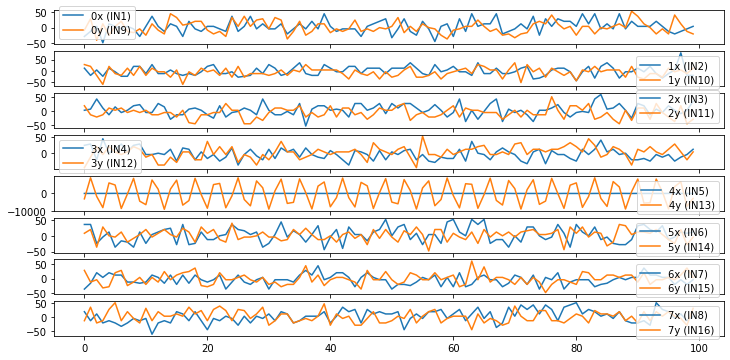

In [4]:
ata_rfsoc_fengine.adc_plot_all(f)
# X-axis: Sample number
# Y-axis: ADC value

All channels 50-ohm terminated except IN1 (antenna 0, X-pol), driven with a 100MHz sine wave at 0 dBm (? Alex, confirm).
Spectrum analyzer for the input signal:
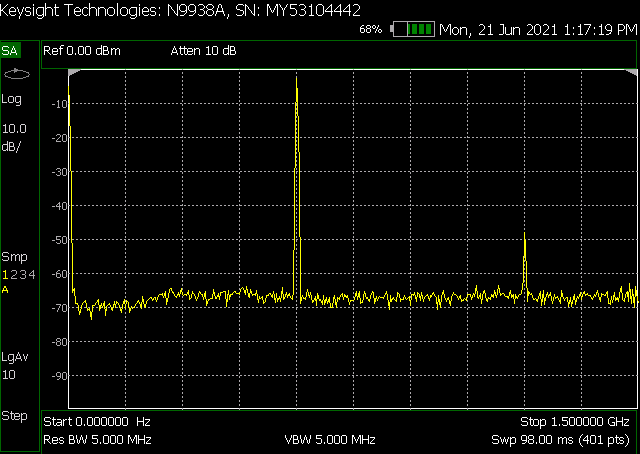

Plotting the driven channel by taking 16 16384-sample snapshots, performing an FFT and averaging power:

In [5]:
spec_software = ata_rfsoc_fengine.adc_get_spec(f, INPUT_ANT, INPUT_POL, 16)
with open('notebook_data/spec_software%s' % file_suffix, 'wb') as fh:
    pickle.dump(spec_software, fh)

Number of channels: 4097
Peak: 88.00 MHz; -69.12 dB
Peak: 248.00 MHz; -69.15 dB
Peak: 512.00 MHz; -69.62 dB
Peak: 594.25 MHz; -69.53 dB
Peak: 595.00 MHz; -69.23 dB
Peak: 596.25 MHz; -67.22 dB
Peak: 600.00 MHz; 0.00 dB
Peak: 604.25 MHz; -68.19 dB
Peak: 848.00 MHz; -45.02 dB
Peak: 936.00 MHz; -69.53 dB


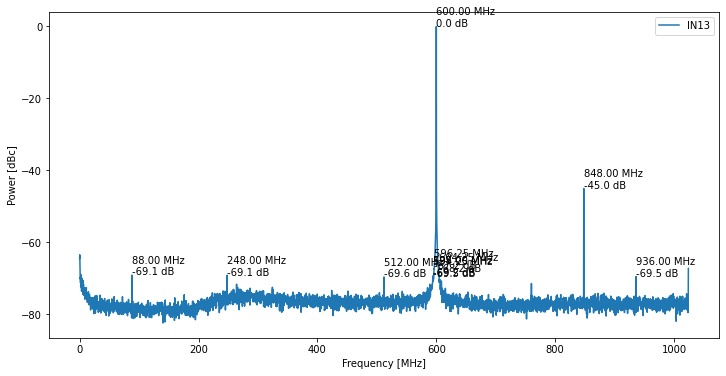

In [6]:
# Nomalize to max
spec_software /= spec_software.max()
spec_db = 10*np.log10(spec_software)
mean_power = np.median(spec_software)
n_chans = spec_software.shape[0]
print("Number of channels: %d" % n_chans)
freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans)
peaks, props = scipy.signal.find_peaks(spec_software, height=5*mean_power)
#print("Peaks found: %d" % peaks.shape[0])
input_name = "IN%d" % (INPUT_ANT + 8 * INPUT_POL + 1)
plt.plot(freq_axis, spec_db, label=input_name)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Power [dBc]")
plt.legend()

for p in peaks:
    # High pass filter peaks
    if freq_axis[p] < 15.:
        continue
    label = "%.2f MHz\n%.1f dB" % (freq_axis[p], spec_db[p])
    pos = (freq_axis[p], spec_db[p])
    plt.annotate(label, pos)
    print("Peak: %.2f MHz; %.2f dB" % (freq_axis[p], spec_db[p]))

RFSoC measures the first spur -45 dB down from the peak, broadly in line with spectrum analyzer. All other peaks are around of below the spectrum analyzer noise floor

Next, grab a similar spectrum using the firmware channelizer. Note that this is not just an FFT, and uses a 4-tap (Hamming-windowed) PFB. Firmware generates 4096 channels.

In [7]:
#spec_firmware, _ = f.spec_read(mode='auto', flush=True, normalize=True)

In [8]:
# # Nomalize to max
# spec_firmware /= spec_firmware.max()
# spec_db = 10*np.log10(spec_firmware)
# med_power = np.median(spec_firmware)
# n_chans = spec_firmware.shape[0]
# print("Number of channels: %d" % n_chans)
# # Firmware throws away nquist bin. Deal with that here
# freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans+1)[0:-1]
# peaks, props = scipy.signal.find_peaks(spec_firmware, height=7*med_power)
# #print("Peaks found: %d" % peaks.shape[0])
# plt.plot(freq_axis, spec_db, label="IN1")
# plt.xlabel("Frequency [MHz]")
# plt.ylabel("Power [dBc]")
# plt.legend()

# for p in peaks:
#     # High pass filter peaks
#     if freq_axis[p] < 15.:
#         continue
#     label = "%.2f MHz\n%.1f dB" % (freq_axis[p], spec_db[p])
#     pos = (freq_axis[p], spec_db[p])
#     plt.annotate(label, pos)
#     print("Peak: %.2f MHz; %.2f dB" % (freq_axis[p], spec_db[p]))

Encouragingly, firmware and software spectra look similar. Examining the difference:

In [9]:
# spec_db_sw = 10*np.log10(spec_software)[0:-1] # Dump the nyquist channel
# spec_db_fw = 10*np.log10(spec_firmware)
# plt.plot(freq_axis, spec_db_fw, 'r', label='firmware')
# plt.plot(freq_axis, spec_db_sw, 'b-', alpha=0.5, label='software')
# plt.legend()

For cross-talk tests, initially the software FFT is used, since this provides access to all of the RFSoC channels

In [10]:
specs = np.zeros([16, 4097])
specs_db = np.zeros([16, 4097])
for ant in range(8):
    for pn, pol in enumerate(['x', 'y']):
        this_input = ant + 8*pn
        print("Capturing input %d" % this_input)
        specs[this_input] = ata_rfsoc_fengine.adc_get_spec(f, ant, pn, 128)
        specs_db[this_input] = 10*np.log10(specs[this_input])
with open('notebook_data/specs%s' % file_suffix, 'wb') as fh:
    pickle.dump(specs, fh)

Capturing input 0
Capturing input 8
Capturing input 1
Capturing input 9
Capturing input 2
Capturing input 10
Capturing input 3
Capturing input 11
Capturing input 4
Capturing input 12
Capturing input 5
Capturing input 13
Capturing input 6
Capturing input 14
Capturing input 7
Capturing input 15


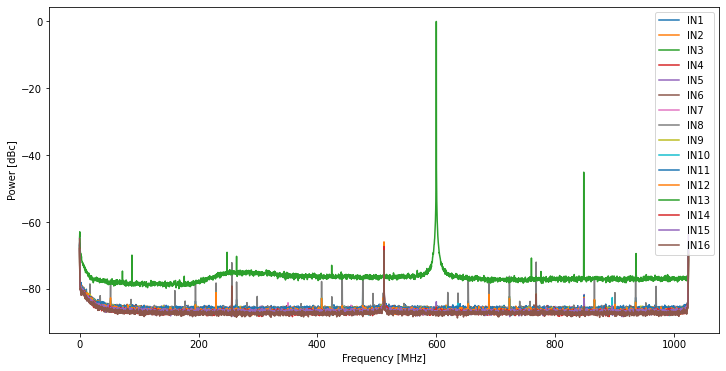

In [11]:
freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., N_CHANS_ADC_FFT)
db_ref = specs_db[INPUT_ANT + 8*INPUT_POL].max()
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

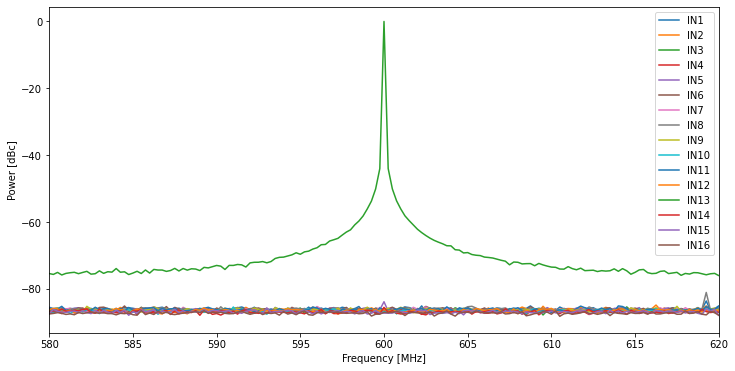

In [12]:
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlim(INPUT_SINE_FREQ_MHZ-20,INPUT_SINE_FREQ_MHZ+20)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

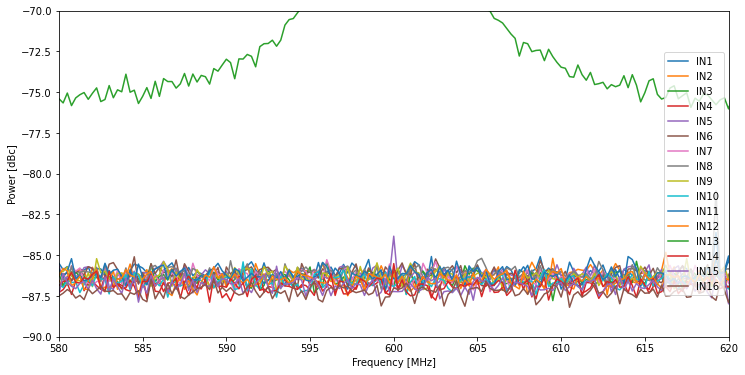

In [13]:
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlim(INPUT_SINE_FREQ_MHZ-20,INPUT_SINE_FREQ_MHZ+20)
plt.ylim(-90, -70)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend(loc='right')

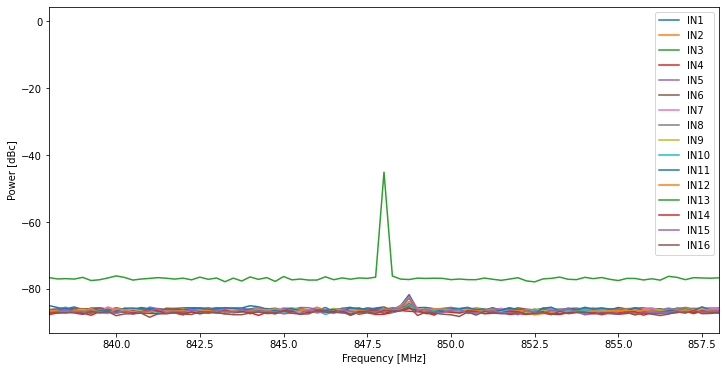

In [14]:
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
# first harmonic
h1 = SAMPLE_RATE_MHZ/2 - (2*INPUT_SINE_FREQ_MHZ - SAMPLE_RATE_MHZ/2)

plt.xlim(h1-10,h1+10)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

Try the firmware accumulators to check IN0 / IN1 cross talk with a long (163.84 ms integration)

In [15]:
# f1 = ata_rfsoc_fengine.AtaRfsocFengine(FPGA_HOST, pipeline_id=1)
# f1.fpga.get_system_information(FPG_FILE)
# # Set the accumulation for the firmware spectrometer
# f1.set_accumulation_length(8*5*1024) # 40960 spectra; 163.84 ms

In [16]:
# x1, y1 = f1.spec_read(mode='auto', flush=True, normalize=True)
# x0, y0 = f.spec_read(mode='auto', flush=True, normalize=True)
# x1_db = 10*np.log10(x1)
# x0_db = 10*np.log10(x0)

In [17]:
# n_chans = 4096
# freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans+1)[0:-1]
# plt.plot(freq_axis, x0_db - x0_db.max(), label='IN0')
# plt.plot(freq_axis, x1_db - x0_db.max(), label='IN1')
# plt.xlim(80,120)
# plt.ylim(-100, -80)